In [40]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn as sk
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

# 1. Read and clean the data

In [2]:
data = pd.read_csv('Combined_News_DJIA.csv')
print(data.shape)


train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']

(1989, 27)


## Word Counts: CountVectorizer

In [3]:
cv_object = CountVectorizer(token_pattern = '[a-zA-Z]{2,}', 
                            lowercase = True, 
                            stop_words = 'english', 
                            min_df = 3,
                            ngram_range = (1,3)
                           )  # do we need to use a N-gram model?

# train set
# build a "single list of strings"
trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row,2:27]))
train_mat = cv_object.fit_transform(trainheadlines)

# test set
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
test_mat = cv_object.transform(testheadlines)

In [4]:
# summary
# dimensions
print(train_mat.shape)
print(test_mat.shape)

# top 15 words
print(cv_object.get_feature_names()[:10])
# many stemming words, emmmmm

(1611, 28577)
(378, 28577)
['aaa', 'aaa credit', 'aaa rating', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandons', 'abbas', 'abbot']


In [5]:
# logistic model
lm = LogisticRegression()
lm.fit(train_mat, train["Label"])

test_yhat = lm.predict(test_mat)

In [6]:
# confusion matrix
confusion = pd.crosstab(test["Label"], test_yhat, rownames=["Actual"], colnames=["Predicted"])
print(confusion)

# misclassification rate
mis = np.mean(test_yhat != test["Label"])
print(mis)

Predicted   0    1
Actual            
0          67  119
1          94   98
0.563492063492


## Word Frequency: TfidVectorizer

In [51]:
tfid = TfidfTransformer(use_idf=True)
train_mat2 = tfid.fit_transform(train_mat)
test_mat2 = tfid.transform(test_mat)

In [8]:
# logistic model
lm = LogisticRegression()
lm.fit(train_mat2, train["Label"])

test_yhat = lm.predict(test_mat2)

# confusion matrix
confusion = pd.crosstab(test["Label"], test_yhat, rownames=["Actual"], colnames=["Predicted"])
print(confusion)

# misclassification rate
mis = np.mean(test_yhat != test["Label"])
print(mis)

Predicted   0    1
Actual            
0          17  169
1          25  167
0.513227513228


## Logistic Lasso

In [55]:
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegression(penalty = 'l1', solver = 'liblinear')
lasso = model.fit(train_mat,train["Label"])
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10]
clf_lasso = LogisticRegressionCV(cv=5,Cs = alphas,penalty = 'l1',solver ='liblinear') # Already normalized
clf_lasso.fit(train_mat,train["Label"])
pred_lassolog_test = clf_lasso.predict(test_mat)
print("Testing Misclassification Rate: ", np.mean(test["Label"] != pred_lassolog_test
))

Testing Misclassification Rate:  0.5264550264550265


## Logistic Ridge

In [49]:
model = LogisticRegression(penalty = 'l2', solver = 'liblinear')
ridge = model.fit(train_mat,train["Label"])
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10]
clf = LogisticRegressionCV(cv=5,Cs = alphas,penalty = 'l2',solver ='liblinear') # Already normalized
clf.fit(train_mat,train["Label"])
pred_lassolog_test = clf.predict(test_mat)
print("Testing Misclassification Rate: ", np.mean(test["Label"] != pred_lassolog_test
))

Testing Misclassification Rate:  0.49206349206349204


## Word Frequency: TfidVectorizer Lasso& Ridge

In [52]:
lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear')
lasso.fit(train_mat2, train["Label"])

test_yhat = lasso.predict(test_mat2)

# confusion matrix
confusion = pd.crosstab(test["Label"], test_yhat, rownames=["Actual"], colnames=["Predicted"])
print(confusion)

# misclassification rate
mis = np.mean(test_yhat != test["Label"])
print(mis)

Predicted    1
Actual        
0          186
1          192
0.49206349206349204


In [53]:
ridge = LogisticRegression(penalty = 'l2', solver = 'liblinear')
ridge.fit(train_mat2, train["Label"])

test_yhat = ridge.predict(test_mat2)

# confusion matrix
confusion = pd.crosstab(test["Label"], test_yhat, rownames=["Actual"], colnames=["Predicted"])
print(confusion)

# misclassification rate
mis = np.mean(test_yhat != test["Label"])
print(mis)

Predicted   0    1
Actual            
0          17  169
1          25  167
0.5132275132275133


Available approaches:
1. Logistic regression/GAM ...
2. Bayesian Models
3. PCA/Matrix factorization
4. LDA/Clustering

Also, we have to deal with the stemming problem (use nltk)

## GAM Time Exceed

In [4]:
from pygam import LinearGAM
from pygam.utils import generate_X_grid

In [24]:
%%capture
train_mat_dense = train_mat.todense()
gam = LinearGAM().gridsearch(train_mat_dense, train["Label"],lam = np.logspace(-5, 3, 30))

In [22]:
train_mat_dense.shape

(1611, 28577)

## Random Forest

In [36]:
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve

In [28]:
RF = ensemble.RandomForestClassifier(n_estimators=500,oob_score=True,random_state = 1).fit(train_mat_dense, train["Label"])

In [60]:
test_mat_dense = test_mat.todense()
pred_RF_prob = RF.predict_proba(test_mat)[:,1]
pred_RF = RF.predict(test_mat)
print("Out-of-bag Misclassification Rate: ", 1 - RF.oob_score_)
print("Misclassification Rate: ", np.mean(pred_RF != test["Label"]))

Out-of-bag Misclassification Rate:  0.4761018001241465
Misclassification Rate:  0.5264550264550265


In [32]:
print("AUC: ", sk.metrics.roc_auc_score(test["Label"],pred_RF_prob))

AUC:  0.47384632616487454


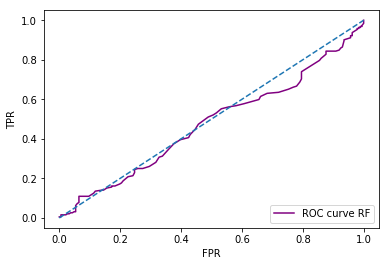

In [41]:
index_RF = np.argsort(pred_RF_prob)
fpr_RF, tpr_RF, _ = roc_curve(test["Label"].iloc[index_RF], pred_RF_prob[index_RF])
plt.figure()
plt.plot(fpr_RF, tpr_RF, color = "purple", label = "ROC curve RF")
plt.plot([0,1],[0,1],linestyle = "--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")

In [54]:
rf = ensemble.RandomForestClassifier(n_estimators=500,oob_score=True,random_state = 1)
rf.fit(train_mat2, train["Label"])

test_yhat = rf.predict(test_mat2)

# confusion matrix
confusion = pd.crosstab(test["Label"], test_yhat, rownames=["Actual"], colnames=["Predicted"])
print(confusion)

# misclassification rate
mis = np.mean(test_yhat != test["Label"])
print(mis)

Predicted   0    1
Actual            
0          21  165
1          42  150
0.5476190476190477


### Lasso + RF

In [61]:
X_good_train = train_mat[:,(clf_lasso.coef_!=0)[0]]
RF_good = ensemble.RandomForestClassifier(n_estimators=500,oob_score=True,random_state = 1).fit(X_good_train,train["Label"])
X_good_test = test_mat[:,(clf_lasso.coef_!=0)[0]]

In [62]:
pred_RF_good_test = RF_good.predict(X_good_test)
pred_RF_good_train = RF_good.predict(X_good_train)
print("Training Misclassification Rate: ", np.mean(pred_RF_good_train != train["Label"]))
print("Out-of-bag Misclassification Rate: ", 1 - RF_good.oob_score_)
print("Testing Misclassification Rate: ", np.mean(pred_RF_good_test != test["Label"]))

Training Misclassification Rate:  0.0
Out-of-bag Misclassification Rate:  0.4003724394785847
Testing Misclassification Rate:  0.4894179894179894
